# EWAS_Aging_whole_blood_adding_gender
DC


In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
plt.rcdefaults()

In [6]:
import csv
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

In [7]:
import os
# Get
os.getcwd()
# Change
os.chdir('/Users/dcox/EWAS age premade')

## Must Set Tissue of Interest

In [8]:
tissue_of_interest = 'whole blood'

## Load other models of cpg lists (optional)

In [9]:
# import pickle

# with open('mod_lg_best_dropNA_XGboost50', 'rb') as fp:
#     mod_lg_best_dropNA_XGboost50 = pickle.load(fp)
    
# with open('Top100cpgs_dropNA_XGboost50', 'rb') as fp:
#     Top100cpgs_dropNA_XGboost50 = pickle.load(fp)
       
# with open('Top42_common_dropNA_corr1000_XGboost50', 'rb') as fp:
#     Top42_common_dropNA_corr1000_XGboost50 = pickle.load(fp) 

# with open('mod_lg_best_dropNA_42common', 'rb') as fp:
#     mod_lg_best_dropNA_42common = pickle.load(fp)

## Functions for Modeling

In [10]:
def test_model_on_heldout_data(X_saved, y_saved, model, mtype='Linear Regression', figsize=(8,4), xlim=None):
    
    # Using  model to make predictions on saved data
    preds_on_saved = model.predict(X_saved)
    MSE_test = mean_squared_error(y_saved, preds_on_saved)
    rms_test = (mean_squared_error(y_saved, preds_on_saved))**0.5
    r2_test = r2_score(y_saved, preds_on_saved)
    MAE_test = mean_absolute_error(y_saved, preds_on_saved)
    r_test_corr = np.corrcoef(y_saved, preds_on_saved)[0,1] # preds_on_saved
    
    # Plotting results
    model_type = mtype

    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.scatter(y_saved, preds_on_saved, alpha=0.5)
    ax.plot(range(20,100), range(20,100), c='red')
    ax.set_xlabel('True Age')
    if xlim !=None:
        ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylabel('Predicted Age')
    ax.grid(True, lw=1.5, ls='--', alpha=0.75)
    ax.set_title(f'{model_type} on Held Out data')
    plt.show()

    # print metric
    print(f'The MSE on the saved data is {MSE_test:.3f} years')
    print(f'The rms on the saved data is {rms_test:.3f} years')
    print(f'The r^2 on the saved data is {r2_test:.3f}')
    print(f'The mae on the saved data is {MAE_test:.3f} years')
    print(f'The correlation on the held out data true-predicted is {r_test_corr:.3f}')
    
    return preds_on_saved, MSE_test, rms_test, r2_test, MAE_test, r_test_corr

In [11]:
# Run Linear Regression model and plot and print results
from sklearn.linear_model import LinearRegression
def linear_regress(X_train, y_train, X_test, y_test, plot=True):
    
    #Build fit model
    mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs='None')
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Linear Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Linear Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAe on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f}')
    
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [12]:
# Function for running XGboost regression and print results
from xgboost import XGBRegressor
def xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=None, plot=True):
    
    #Build fit model
    XG = XGBRegressor(objective='reg:squarederror',
                    n_estimators=200,
                    min_child_weight=1,
                    max_depth=3,
                    subsample=0.7,
                    colsample_bytree=0.5,
                    learning_rate=0.1)
    
    eval_set = [(X_train, y_train),(X_test, y_test)]
    XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds, eval_set=eval_set, verbose=False)
    
    
    # Make predictions and evaluate
    preds_train = XG.predict(X_train)
    preds_test = XG.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    results = XG.evals_result()
    epochs = len(results['validation_0']['rmse'])
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,3, figsize=(16,3.5))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('XGboost on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('XGboost on testing data')

        x_axis = range(0, epochs)
        ax[2].plot(x_axis, results['validation_0']['rmse'], label='Train')
        ax[2].plot(x_axis, results['validation_1']['rmse'], label='Test')
        ax[2].legend()
        ax[2].set_ylabel('rms')
        ax[2].set_xlabel('epoch')
        ax[2].set_title('XGBoost rms')
        plt.show()
    
    # print metric
    print(f'The number of training epochs was {epochs}')
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAE on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    
    
    return XG, rms_train, rms_test, r2_train, r2_test, XG.feature_importances_

In [13]:
# Function for running a ridge Regression model with CV on alpha
# and plot and print results
from sklearn.linear_model import RidgeCV
def ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = mod = RidgeCV(alphas=alphas,cv=cv)
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Ridge Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Ridge Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAE on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    print(f'Optimal alpha from CV = {mod.alpha_}')
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [14]:
# Function for running a lasso Regression model with CV on alpha
# and plot and print results
from sklearn.linear_model import LassoCV
def lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = mod = LassoCV(alphas=alphas,cv=cv)
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Lasso Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Lasso Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAE on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    print(f'Optimal alpha from CV = {mod.alpha_}')
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [15]:
# repeat_XGBoost numtrials times using a different split each time 
# returns importance scores for each run in a df 
def repeat_XGBoost(df_processed, numtrials, early_stopping_rounds = 10, start_column=2, test_size=0.20):
    X = df_processed.iloc[:,start_column:]
    y = df_processed.age
    importances = []
    rms_train = []
    rms_test = []
    r2_train = []
    r2_test = []
    for i in range(numtrials): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        
        XG = XGBRegressor(objective='reg:squarederror',
                    n_estimators=200,
                    min_child_weight=1,
                    max_depth=3,
                    subsample=0.7,
                    colsample_bytree=0.5,
                    learning_rate=0.1)
    
        eval_set = [(X_train, y_train),(X_test, y_test)]
        XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds, eval_set=eval_set, verbose=False)
        
        preds_train = XG.predict(X_train)
        preds_test = XG.predict(X_test)
        rms_train.append((mean_squared_error(y_train, preds_train))**0.5)
        rms_test.append((mean_squared_error(y_test, preds_test))**0.5)
        r2_train.append(r2_score(y_train, preds_train))
        r2_test.append(r2_score(y_test, preds_test))
        print(i+1, f'r^2 test = {r2_score(y_test, preds_test)}')
        importances.append(XG.feature_importances_)
    df_imp = pd.DataFrame(importances, columns = df_processed.columns[2:])
    df_imp = df_imp.transpose()
    cols = []
    for i in range(1,numtrials+1):
        cols.append('trial_'+str(i))
    df_imp.columns = cols
    df_imp['Mean'] = df_imp.mean(axis=1)
    df_imp['Std'] = df_imp.std(axis=1)
    return df_imp, rms_train, rms_test, r2_train, r2_test

# Takes df of importance scores produced by repeat_XGBoost and sorts by mean imp score
def importances_sorted_by_mean(df_imp):
    df_imp_sorted = df_imp.sort_values('Mean', ascending=False)
    return df_imp_sorted

# Makes a histogram of the frequecy of cgs in the top (top_num) importance scores
def histogram_of_top_CpGs_by_importance(df_imp, top_num=20):
    vs = []
    inds = []
    for col in df_imp.columns[:-2]:
        c = df_imp[col].sort_values(ascending=False)
        vs.append(c[:top_num])
        inds  = inds + list(c.index[:top_num])
    h = pd.Series(inds).value_counts()
    # Plotting the first 100 importance scores
    plt.figure(figsize = (30, 12))
    plt.bar(h.index[:100],h[:100])
    plt.title('Frequency of CpGs in the top 100 importances')
    plt.ylabel('Frequency')
    plt.xlabel('CpG')
    plt.xticks(fontsize = 16, rotation=90)
    plt.show()
    return inds, vs, h

In [16]:
# repeat_XGBoost numtrials times using a different split each time 
# returns importance scores for each run in a df 
def repeat_XGBoost_II(df_processed, numtrials, early_stopping_rounds = 10, start_column=2, test_size=0.20):
    X = df_processed.iloc[:, start_column:]
    y = df_processed.age
    importances = []
    mse_train = []
    mse_test = []
    rmse_train = []
    rmse_test = []
    r2_train = []
    r2_test = []
    models = []
    for i in range(numtrials): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        
        XG = XGBRegressor(objective='reg:squarederror',
                    n_estimators=200,
                    min_child_weight=1,
                    max_depth=3,
                    subsample=0.7,
                    colsample_bytree=0.5,
                    learning_rate=0.1)
    
        eval_set = [(X_train, y_train),(X_test, y_test)]
        XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds, eval_set=eval_set, verbose=False)
        
        preds_train = XG.predict(X_train)
        preds_test = XG.predict(X_test)
        mse_train.append(mean_squared_error(y_train, preds_train))
        mse_test.append(mean_squared_error(y_test, preds_test))
        rmse_train.append((mean_squared_error(y_train, preds_train))**0.5)
        rmse_test.append((mean_squared_error(y_test, preds_test))**0.5)
        r2_train.append(r2_score(y_train, preds_train))
        r2_test.append(r2_score(y_test, preds_test))
        print(i+1, f'r^2 test = {r2_score(y_test, preds_test)}')
        importances.append(XG.feature_importances_)
        models.append(XG)
    df_imp = pd.DataFrame(importances, columns = df_processed.columns[2:])
    df_imp = df_imp.transpose()
    cols = []
    for i in range(1,numtrials+1):
        cols.append('trial_'+str(i))
    df_imp.columns = cols
    df_imp['Mean'] = df_imp.mean(axis=1)
    df_imp['Std'] = df_imp.std(axis=1)
    return df_imp, mse_train, mse_test, rmse_train, rms_test, r2_train, r2_test, models

In [17]:
# repeat_XGBoost numtrials times using a different split each time 
# returns importance scores for each run in a df 
import xgboost
import shap

def repeat_XGBoost_shap(df_processed, numtrials, early_stopping_rounds = 10, test_size=0.20):
    X = df_processed.iloc[:, 2:]
    y = df_processed.age
    abs_shap_means = []
    models = []
    for i in range(numtrials): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        
        XG = XGBRegressor(objective='reg:squarederror',
                    n_estimators=200,
                    min_child_weight=1,
                    max_depth=3,
                    subsample=0.7,
                    colsample_bytree=0.5,
                    learning_rate=0.1)
    
        eval_set = [(X_train, y_train),(X_test, y_test)]
        XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds, eval_set=eval_set, verbose=False)
        print('explainer')
        explainer = shap.Explainer(XG)
        print('shap_values')
        shap_values = explainer(X_test)
        print('abs_shap_values')
        abs_shap_values = np.abs(shap_values)
        print('abs_shap_mean')
        abs_shap_means.append(np.mean(abs_shap_values, axis=0))
        print('saving model')
        models.append(XG)
        print(i+1)
        
    df_shap = pd.DataFrame(abs_shap_means, columns = df_processed.columns[2:])
    df_shap = df_shap.transpose()
    cols = []
    for i in range(1,numtrials+1):
        cols.append('trial_'+str(i))
    df_shap.columns = cols
    df_shap['Mean'] = df_shap.mean(axis=1)
    df_shap['Std'] = df_shap.std(axis=1)
    return df_shap, models

### Function for loading data file and writing subset file by tissue, uses csv package for speed, not pandas

In [18]:
import math
import csv
import re

def findElements(lst1, lst2):
    '''
    returns a list of those elements in list1 that are at the position indices given in list2
    '''
    return [lst1[i] for i in lst2] 

def read_write_age_data_by_tissue(file_in, file_out, search_term, num_rows='all'):
    '''
    Built to operate on the EWAS aging dataset text file named 'age_methylation_v1.txt'
    
    Takes an input csv file, a file name to write to, and a search term which should equal a type of tissue 
    in the tissue row of the data (3rd row).
    
    Writes to a csv file the input data but containingg only the columns with tissue containing any where in it
    the search term
    
    params: 
        file_in (string) (file.csv) path to some existing csv file to read
        file_out (string) name of csv file to write 
        search_term (string) term to search for in tissue row
        
    returns:
        None
    '''
    with open(file_in, 'r') as file_in:

        csv_in = csv.reader(file_in,delimiter= '\t')

        header = next(csv_in)
        age = next(csv_in)
        tissue = next(csv_in)
       
        indices = [0]
        for i, element in enumerate(tissue):
            if re.search(search_term, element):
                indices.append(i)
            
        if len(indices) == 0:
            print('Tissue not found')
            return None 
        
        with open(file_out, 'w') as f_out:
            line_list = []
            csv_out = csv.writer(f_out)

            new_header =  findElements(header, indices)
            new_age =  findElements(age, indices)
            new_tissue =  findElements(tissue, indices)

            csv_out.writerow(new_header)
            #csv_out.writerow(new_age)
            #csv_out.writerow(new_tissue)

            count = 0
            if num_rows=='all':
                for line in csv_in:
                    save = findElements(line, indices)
                    csv_out.writerow(save)
                    count +=1
                    if count%10000 == 0:
                        print(f'finished line {count}')
            else:
                for line in csv_in:
                    if count >= num_rows:
                        break
                    else:
                        save = findElements(line, indices)
                        csv_out.writerow(save)
                        count +=1
                        if count%10000 == 0:
                            print(f'finished line {count}')
        return new_header, new_age, new_tissue

        print(f'\n{count} lines sent to file {file_out} with the tissue field containing {search_term}')

## Loading Data to dataframe

### Read data file and write new file with data from the selected tissue

In [19]:
'./age_methylation_v1/'+ tissue_of_interest + '_age_methylation_v1.txt'

'./age_methylation_v1/whole blood_age_methylation_v1.txt'

In [20]:
%%time
# Writing data to a file with the above function selecting out a certain tissue
file_out = './age_methylation_v1/'+ tissue_of_interest + '_age_methylation_v1.txt'
new_header, new_age, new_tissue = read_write_age_data_by_tissue('./age_methylation_v1/age_methylation_v1.txt', file_out, tissue_of_interest, num_rows='all')

finished line 10000
finished line 20000
finished line 30000
finished line 40000
finished line 50000
finished line 60000
finished line 70000
finished line 80000
finished line 90000
finished line 100000
finished line 110000
finished line 120000
finished line 130000
finished line 140000
finished line 150000
finished line 160000
finished line 170000
finished line 180000
finished line 190000
finished line 200000
finished line 210000
finished line 220000
finished line 230000
finished line 240000
finished line 250000
finished line 260000
finished line 270000
finished line 280000
finished line 290000
finished line 300000
finished line 310000
finished line 320000
finished line 330000
finished line 340000
finished line 350000
finished line 360000
finished line 370000
finished line 380000
finished line 390000
finished line 400000
finished line 410000
finished line 420000
finished line 430000
finished line 440000
finished line 450000
finished line 460000
finished line 470000
finished line 480000
C

### Read back in data in chunks and combine to new dataframe

In [21]:
%%time
# Reading data back in in chunks
import warnings
warnings.simplefilter(action='ignore', category=Warning)

chunksize = 10000
dfs = []
df_chunk = pd.read_csv(file_out, header=0, chunksize=chunksize)
for chunk in df_chunk:
    dfs.append(chunk)

CPU times: user 1min 16s, sys: 6.37 s, total: 1min 22s
Wall time: 1min 23s


In [22]:
%%time
# Combining chunks into 1 dataframe
df = pd.concat(dfs).set_index('sample_id') 

CPU times: user 5.33 s, sys: 22 s, total: 27.4 s
Wall time: 1min 1s


### Transpose dataframe so cpgs are columns, and add columns for age and tissue saved from the write operation

In [23]:
%%time
# transposing dataframe
df_t = df.transpose()

CPU times: user 3.82 ms, sys: 8.86 ms, total: 12.7 ms
Wall time: 15.7 ms


### Function to get meta data from the metadate file and extract values for the samples of interest and column of interest

In [24]:
meta_file = './sample_age_methylation_v1-2/sample_age.txt'

def get_meta(meta_file, index, column, delimiter=' '):
    df_meta = pd.read_csv(meta_file, delimiter=delimiter)
    extracted = []
    for sample in index:
        extracted.append(df_meta.loc[sample, column])
    return extracted
        

In [25]:
# get sex from metadata file for the current samples
sex = get_meta(meta_file, df_t.index, 'sex', delimiter=' ')

In [26]:
len(sex)

1802

In [27]:
# Inserting columns for tissue and age and sex
# and setting age dtype to float and then rounding to int
# Converting sex from M mand F to 1 and 0
df_t.insert(0, 'age', new_age[1:])
df_t.insert(0, 'tissue', new_tissue[1:])
df_t.age = df_t.age.astype('float')
df_t.age = df_t.age.apply(np.rint)
df_t.age = df_t.age.astype('int64')
df_t.insert(2, 'sex', sex)
df_t.sex = 1*(df_t.sex=='M') # 1 = M, 0 = F

In [28]:
df_t

sample_id,tissue,age,sex,cg00050873,cg00212031,cg00213748,cg00214611,cg00455876,cg01707559,cg02004872,cg02011394,cg02050847,cg02233190,cg02494853,cg02839557,cg02842889,cg03052502,cg03155755,cg03244189,cg03443143,cg03683899,cg03695421,cg03706273,cg03750315,cg03767353,cg04016144,cg04023335,cg04042030,cg04303809,cg04448376,cg04462340,cg04689676,cg04792227,cg04840163,cg04964672,cg05213048,cg05230942,cg05480730,cg05544622,cg05621349,cg05865243,cg05890011,cg06322277,cg06479204,cg07731488,cg07747963,cg07939587,cg08242338,cg08265308,cg08921682,...,ch.22.11243R,ch.22.16108507R,ch.22.16454022F,ch.22.40657F,ch.22.78028F,ch.22.17803970R,ch.22.107403R,ch.22.137888R,ch.22.138449R,ch.22.147839R,ch.22.149158R,ch.22.163059F,ch.22.22597277R,ch.22.217069R,ch.22.22928834R,ch.22.243204R,ch.22.23746271F,ch.22.25752197R,ch.22.26167205F,ch.22.317144R,ch.22.26442001R,ch.22.363412F,ch.22.28920330F,ch.22.30020508R,ch.22.427671F,ch.22.436090R,ch.22.439136F,ch.22.441164F,ch.22.467397R,ch.22.31817810F,ch.22.33863861F,ch.22.528917R,ch.22.533187F,ch.22.569473R,ch.22.38010425R,ch.22.694298R,ch.22.707049R,ch.22.707968R,ch.22.728807R,ch.22.734399R,ch.22.740407F,ch.22.757911F,ch.22.772318F,ch.22.43177094F,ch.22.44116734F,ch.22.909671F,ch.22.46830341F,ch.22.1008279F,ch.22.47579720R,ch.22.48274842R
GSM2334366,whole blood,94,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.205,NaN,NaN,NaN,0.139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.001,0.002,0.012,0.012,0.160,0.013,0.121,NaN,NaN,NaN,0.012,0.016,0.003,0.014,NaN,0.011,0.002,0.008,0.014,0.009,0.006,0.018,0.009,0.017,NaN,0.012,0.008,0.005,0.010,0.045,NaN,0.011,0.109,0.016,0.011,0.004,0.003,NaN,NaN,0.006,0.010,0.003,0.004,0.015,NaN,0.010,0.001,0.047,0.012
GSM989882,whole blood,96,1,0.861,0.126,NaN,0.025,NaN,0.163,0.013,0.970,0.988,0.012,0.065,0.092,0.017,0.990,0.919,0.155,0.914,0.014,0.855,0.079,0.027,0.897,0.956,0.590,0.034,0.118,NaN,0.936,0.022,0.181,0.098,0.899,0.833,NaN,0.006,0.972,0.030,0.979,NaN,0.925,0.067,0.010,NaN,0.903,0.985,0.925,0.636,...,0.059,0.000,0.006,0.012,0.008,0.157,0.007,0.139,NaN,NaN,NaN,0.029,0.008,0.004,0.016,NaN,0.007,0.004,0.006,0.012,0.008,NaN,0.022,0.003,0.012,NaN,0.015,0.002,0.004,0.017,0.052,0.023,0.010,0.140,0.022,0.013,0.004,0.003,0.085,NaN,0.005,0.011,0.004,0.003,0.005,0.061,0.017,0.001,0.051,0.010
GSM989863,whole blood,101,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008,NaN,NaN,NaN,0.117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.040,0.002,0.002,0.014,0.021,0.155,0.011,0.177,NaN,NaN,NaN,0.023,0.013,0.002,0.007,NaN,0.004,0.004,0.008,0.014,0.012,NaN,0.020,0.003,0.017,NaN,0.010,0.004,0.002,0.009,0.061,0.029,0.008,0.152,0.015,0.013,0.000,0.005,0.090,NaN,0.008,0.009,0.016,0.002,0.022,0.033,0.009,0.001,0.057,0.008
GSM1443696,whole blood,99,1,0.834,0.006,NaN,0.009,0.745,0.070,0.011,0.944,0.984,0.013,0.013,0.040,0.012,0.984,0.928,0.062,0.887,0.006,0.830,0.017,0.040,0.796,0.959,0.477,0.008,0.103,NaN,NaN,0.026,0.269,0.090,0.880,0.715,NaN,0.013,0.959,0.026,0.986,0.007,NaN,0.072,0.010,NaN,0.753,0.985,0.901,0.625,...,NaN,0.019,0.005,NaN,0.069,0.161,0.001,0.111,NaN,NaN,NaN,NaN,0.002,0.014,0.016,NaN,0.016,0.002,0.002,NaN,0.005,NaN,NaN,0.011,0.005,NaN,NaN,NaN,0.003,0.009,0.026,NaN,0.002,0.122,0.005,NaN,NaN,0.006,NaN,NaN,0.011,0.027,NaN,0.000,NaN,NaN,0.003,0.002,0.033,0.003
GSM1069241,whole blood,99,1,0.834,0.006,NaN,0.009,0.745,0.070,0.011,0.944,0.984,0.013,0.013,0.040,0.012,0.984,0.928,0.062,0.887,0.006,0.830,0.017,0.040,0.796,0.959,0.477,0.008,0.103,NaN,NaN,0.026,0.269,0.090,0.880,0.715,NaN,0.013,0.959,0.026,0.986,0.007,NaN,0.072,0.010,NaN,0.753,0.985,0.901,0.625,...,NaN,0.019,0.005,NaN,0.069,0.161,0.001,0.111,NaN,NaN,NaN,NaN,0.002,0.014,0.016,NaN,0.016,0.002,0.002,NaN,0.005,NaN,NaN,0.011,0.005,NaN,NaN,NaN,0.003,0.009,0.026,NaN,0.002,0.122,0.005,NaN,NaN,0.006,NaN,NaN,0.011,0.027,NaN,0.000,NaN,NaN,0.003,0.002,0

### Dealing with NAs, remove columns with more than 25% NAs, Impute the rest with mean of columns

CPU times: user 7.23 s, sys: 5.72 s, total: 13 s
Wall time: 13.1 s


Text(0, 0.5, 'count')

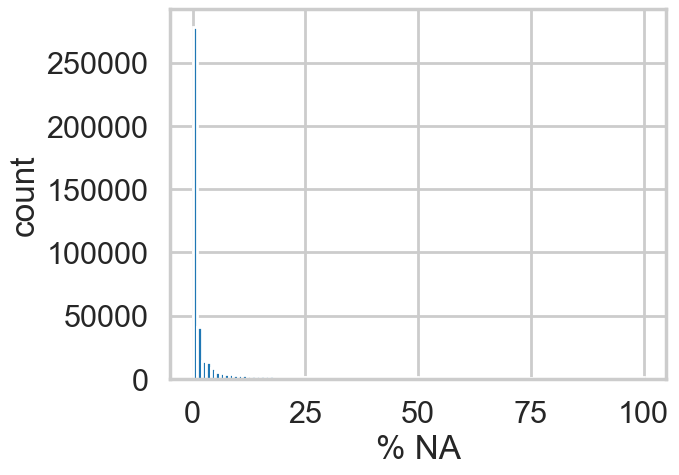

In [29]:
%%time
#looking at a histogram of the percent NAs for the columns
num_nans_hist = 100 * df_t.isna().sum(axis=0)/df_t.shape[0]
num_nans_hist.hist(bins=100)
plt.xlabel('% NA')
plt.ylabel('count')
#plt.ylim(0,50000)

#### Drop all columns with  NAs > 25% of values , then imput with mean of column

In [30]:
# remove columns with more than 25% NAs
df_processed_imp = df_t.dropna(thresh = 0.75*df_t.shape[0], axis=1)

In [31]:
df_processed_imp.shape

(1802, 406629)

In [32]:
%%time
# Impute all values with column mean
df_processed_imp = df_processed_imp.fillna(df_processed_imp.mean())

CPU times: user 6min 10s, sys: 4min 42s, total: 10min 52s
Wall time: 47min 52s


In [33]:
%%time
# df_processed_imp.to_csv('df_EWAS_aging_whole_blood_Imputated_with_mean')

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.72 µs


### Selecting out samples with ages over 20 years old

In [34]:
# Selecting out samples with age > 20
df_processed_imp_over20 = df_processed_imp[df_processed_imp.age >=20]

### Histogram of ages in data

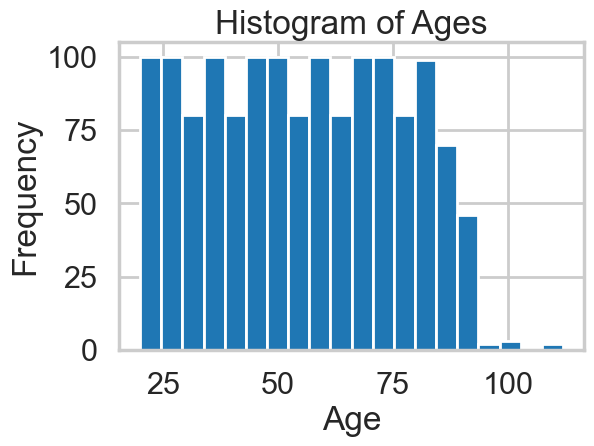

In [35]:
# Histogram of ages in data
plt.figure(figsize = (6,4))
df_processed_imp_over20.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Ages')
plt.show()

### Dividing data into working and saved parts (75/25 split)

In [36]:
df_processed_imp_over20.shape

(1422, 406629)

In [37]:
# Splitting data into Working and Saved by random selection of rows

import random

num_samples = df_processed_imp_over20.shape[0]
num_for_saving = int(round(df_processed_imp_over20.shape[0]*.25))

np.random.seed(2021)

saved_index = np.random.choice(np.arange(num_samples), size=num_for_saving, replace=False)
keep_index = []
for num in range(num_samples):
    if num not in saved_index:
        keep_index.append(num)

df_p_saved = df_processed_imp_over20.iloc[saved_index, :]
df_p_working = df_processed_imp_over20.iloc[keep_index, :]

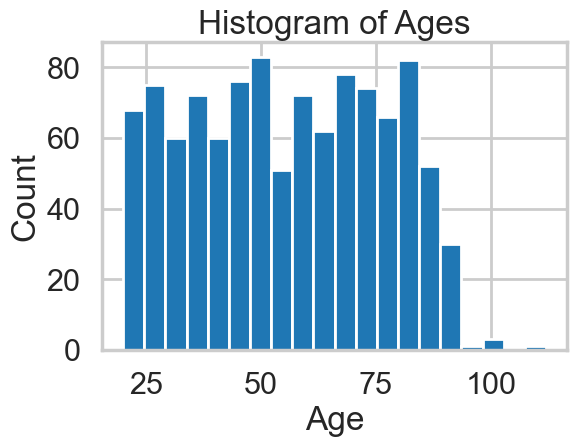

In [38]:
# Histogram of ages in saved data
plt.figure(figsize=(6,4))
df_p_working.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages')
plt.show()

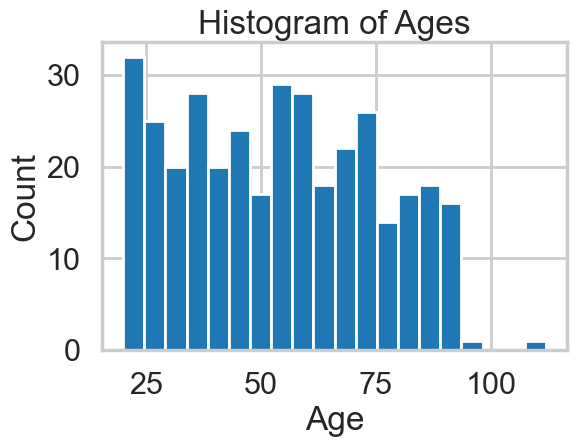

In [39]:
# Histogram of ages in working data
plt.figure(figsize=(6,4))
df_p_saved.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages')
plt.show()

In [40]:
df_p_working

sample_id,tissue,age,sex,cg02494853,cg03706273,cg04023335,cg05213048,cg15295597,cg26520468,cg27539833,cg00008945,cg00011200,cg00011891,cg00014152,cg00016522,cg00016934,cg00018261,cg00021786,cg00026186,cg00072288,cg00072839,cg00074638,cg00112256,cg00114625,cg00114913,cg00116709,cg00139317,cg00140085,cg00142683,cg00192980,cg00200463,cg00206414,cg00240113,cg00241296,cg00241907,cg00243584,cg00264378,cg00265812,cg00266918,cg00360365,cg00373606,cg00374088,cg00378717,cg00378950,cg00380985,cg00381376,cg00391044,cg00399450,cg00408231,cg00412010,...,cg27592453,cg27598806,cg27601574,cg27611781,cg27612019,cg27614432,cg27634071,cg27648216,cg27656573,cg27657363,cg27657537,cg27660038,cg27662611,cg27665648,ch.22.16108507R,ch.22.16454022F,ch.22.40657F,ch.22.78028F,ch.22.17803970R,ch.22.107403R,ch.22.137888R,ch.22.22597277R,ch.22.217069R,ch.22.22928834R,ch.22.23746271F,ch.22.25752197R,ch.22.26167205F,ch.22.317144R,ch.22.26442001R,ch.22.28920330F,ch.22.30020508R,ch.22.427671F,ch.22.439136F,ch.22.467397R,ch.22.31817810F,ch.22.33863861F,ch.22.533187F,ch.22.569473R,ch.22.38010425R,ch.22.694298R,ch.22.707049R,ch.22.707968R,ch.22.740407F,ch.22.757911F,ch.22.43177094F,ch.22.44116734F,ch.22.46830341F,ch.22.1008279F,ch.22.47579720R,ch.22.48274842R
GSM2334366,whole blood,94,0,0.078,0.205,0.139,0.904,0.120,0.970,0.912,0.276,0.616,0.602,0.986000,0.577,0.274000,0.612,0.888,0.551,0.415,0.112,0.672,0.526,0.641,0.367000,0.630,0.561,0.485,0.579,0.662,0.635,0.449,0.480,0.256,0.288,0.522,0.616,0.602,0.091,0.141963,0.583,0.519,0.019,0.900,0.607,0.017,0.397,0.577,0.532,0.448,...,0.943,0.948000,0.962,0.064000,0.953,0.020,0.035,0.977,0.975,0.924,0.087,0.096,0.023000,0.882,0.001000,0.002000,0.012000,0.012000,0.160,0.013,0.121,0.016,0.003000,0.014000,0.011,0.002,0.008,0.01400,0.009,0.018000,0.00900,0.017,0.012000,0.005,0.010,0.045,0.011,0.109,0.016,0.011000,0.004000,0.003,0.006000,0.010000,0.004,0.015000,0.010,0.001000,0.047,0.012
GSM989863,whole blood,101,0,0.013,0.008,0.117,0.756,0.033,0.958,0.933,0.324,0.509,0.519,0.985000,0.529,0.100000,0.629,0.955,0.490,0.318,0.072,0.664,0.569,0.594,0.475000,0.575,0.533,0.420,0.566,0.558,0.520,0.201,0.453,0.293,0.473,0.454,0.434,0.589,0.076,0.143000,0.443,0.401,0.014,0.873,0.473,0.007,0.471,0.554,0.678,0.447,...,0.907,0.952000,0.967,0.067000,0.649,0.032,0.028,0.967,0.969,0.851,0.093,0.067,0.023000,0.856,0.002000,0.002000,0.014000,0.021000,0.155,0.011,0.177,0.013,0.002000,0.007000,0.004,0.004,0.008,0.01400,0.012,0.020000,0.00300,0.017,0.010000,0.002,0.009,0.061,0.008,0.152,0.015,0.013000,0.000000,0.005,0.008000,0.009000,0.002,0.022000,0.009,0.001000,0.057,0.008
GSM1443696,whole blood,99,1,0.013,0.017,0.477,0.715,0.017,0.966,0.932,0.010,0.014,0.025,0.980993,0.011,0.034000,0.017,0.983,0.002,0.018,0.051,0.632,0.029,0.009,0.052000,0.015,0.018,0.059,0.033,0.035,0.025,0.033,0.038,0.034,0.012,0.285,0.008,0.018,0.024,0.019000,0.021,0.060,0.013,0.933,0.051,0.006,0.088,0.018,0.964,0.152,...,0.859,0.974000,0.966,0.100000,0.746,0.014,0.020,0.973,0.979,0.861,0.033,0.082,0.032000,0.886,0.019000,0.005000,0.026326,0.069000,0.161,0.001,0.111,0.002,0.014000,0.016000,0.016,0.002,0.002,0.01984,0.005,0.031775,0.01100,0.005,0.011401,0.003,0.009,0.026,0.002,0.122,0.005,0.025891,0.013469,0.006,0.011000,0.027000,0.000,0.012976,0.003,0.002000,0.033,0.003
GSM1069241,whole blood,99,1,0.013,0.017,0.477,0.715,0.017,0.966,0.932,0.010,0.014,0.025,0.980993,0.011,0.034000,0.017,0.983,0.002,0.018,0.051,0.632,0.029,0.009,0.052000,0.015,0.018,0.059,0.033,0.035,0.025,0.033,0.038,0.034,0.012,0.285,0.008,0.018,0.024,0.019000,0.021,0.060,0.013,0.933,0.051,0.006,0.088,0.018,0.964,0.152,...,0.859,0.974000,0.966,0.100000,0.746,0.014,0.020,0.973,0.979,0.861,0.033,0.082,0.032000,0.886,0.019000,0.005000,0.026326,0.069000,0.161,0.001,0.111,0.002,0.014000,0.016000,0.016,0.002,0.002,0.01984,0.005,0.031775,0.01100,0.005,0.011401,0.003,0.009,0.026,0.002,0.122,0.005,0.025891,0.013469,0.006,0.011000,0.027000,0.000,0.012976,0.003,0.002000,0.033,0.003
GSM1572442,whole blood,112,0,0.036,

### Running XGboost 50 times to identify top 100 cpgs

In [41]:
# %%time
# df_imp, mse_train, mse_test, rmse_train, rms_test, r2_train, r2_test, models =repeat_XGBoost_II(df_p_working, 1, test_size=0.20)

In [42]:
%%time
# # Runnin XGboost on working dataset 50 times with 50 different train/test splits
# # This can take many hours (on whole blood 10 hrs)
# df_imp, rms_train, rms_test, r2_train, r2_test = repeat_XGBoost(df_p_working, 50, test_size=0.20)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


In [43]:
# df_imp

In [44]:
# write 50 trials results to a file, so don't have to rerun the 50 XGboost trials with the whole dataset again
# file = 'df_importance_EWAS_age_' + tissue_of_interest + '_50_trials.csv'
#df_imp.to_csv(file)
df_imp = pd.read_csv('./blood/df_importance_EWAS_age_whole_blood_50_trials.csv' , index_col=0)

In [45]:
# Finding cpgs with on average the highest importance scores, see mean columnn in df below
df_imp_sorted = importances_sorted_by_mean(df_imp)

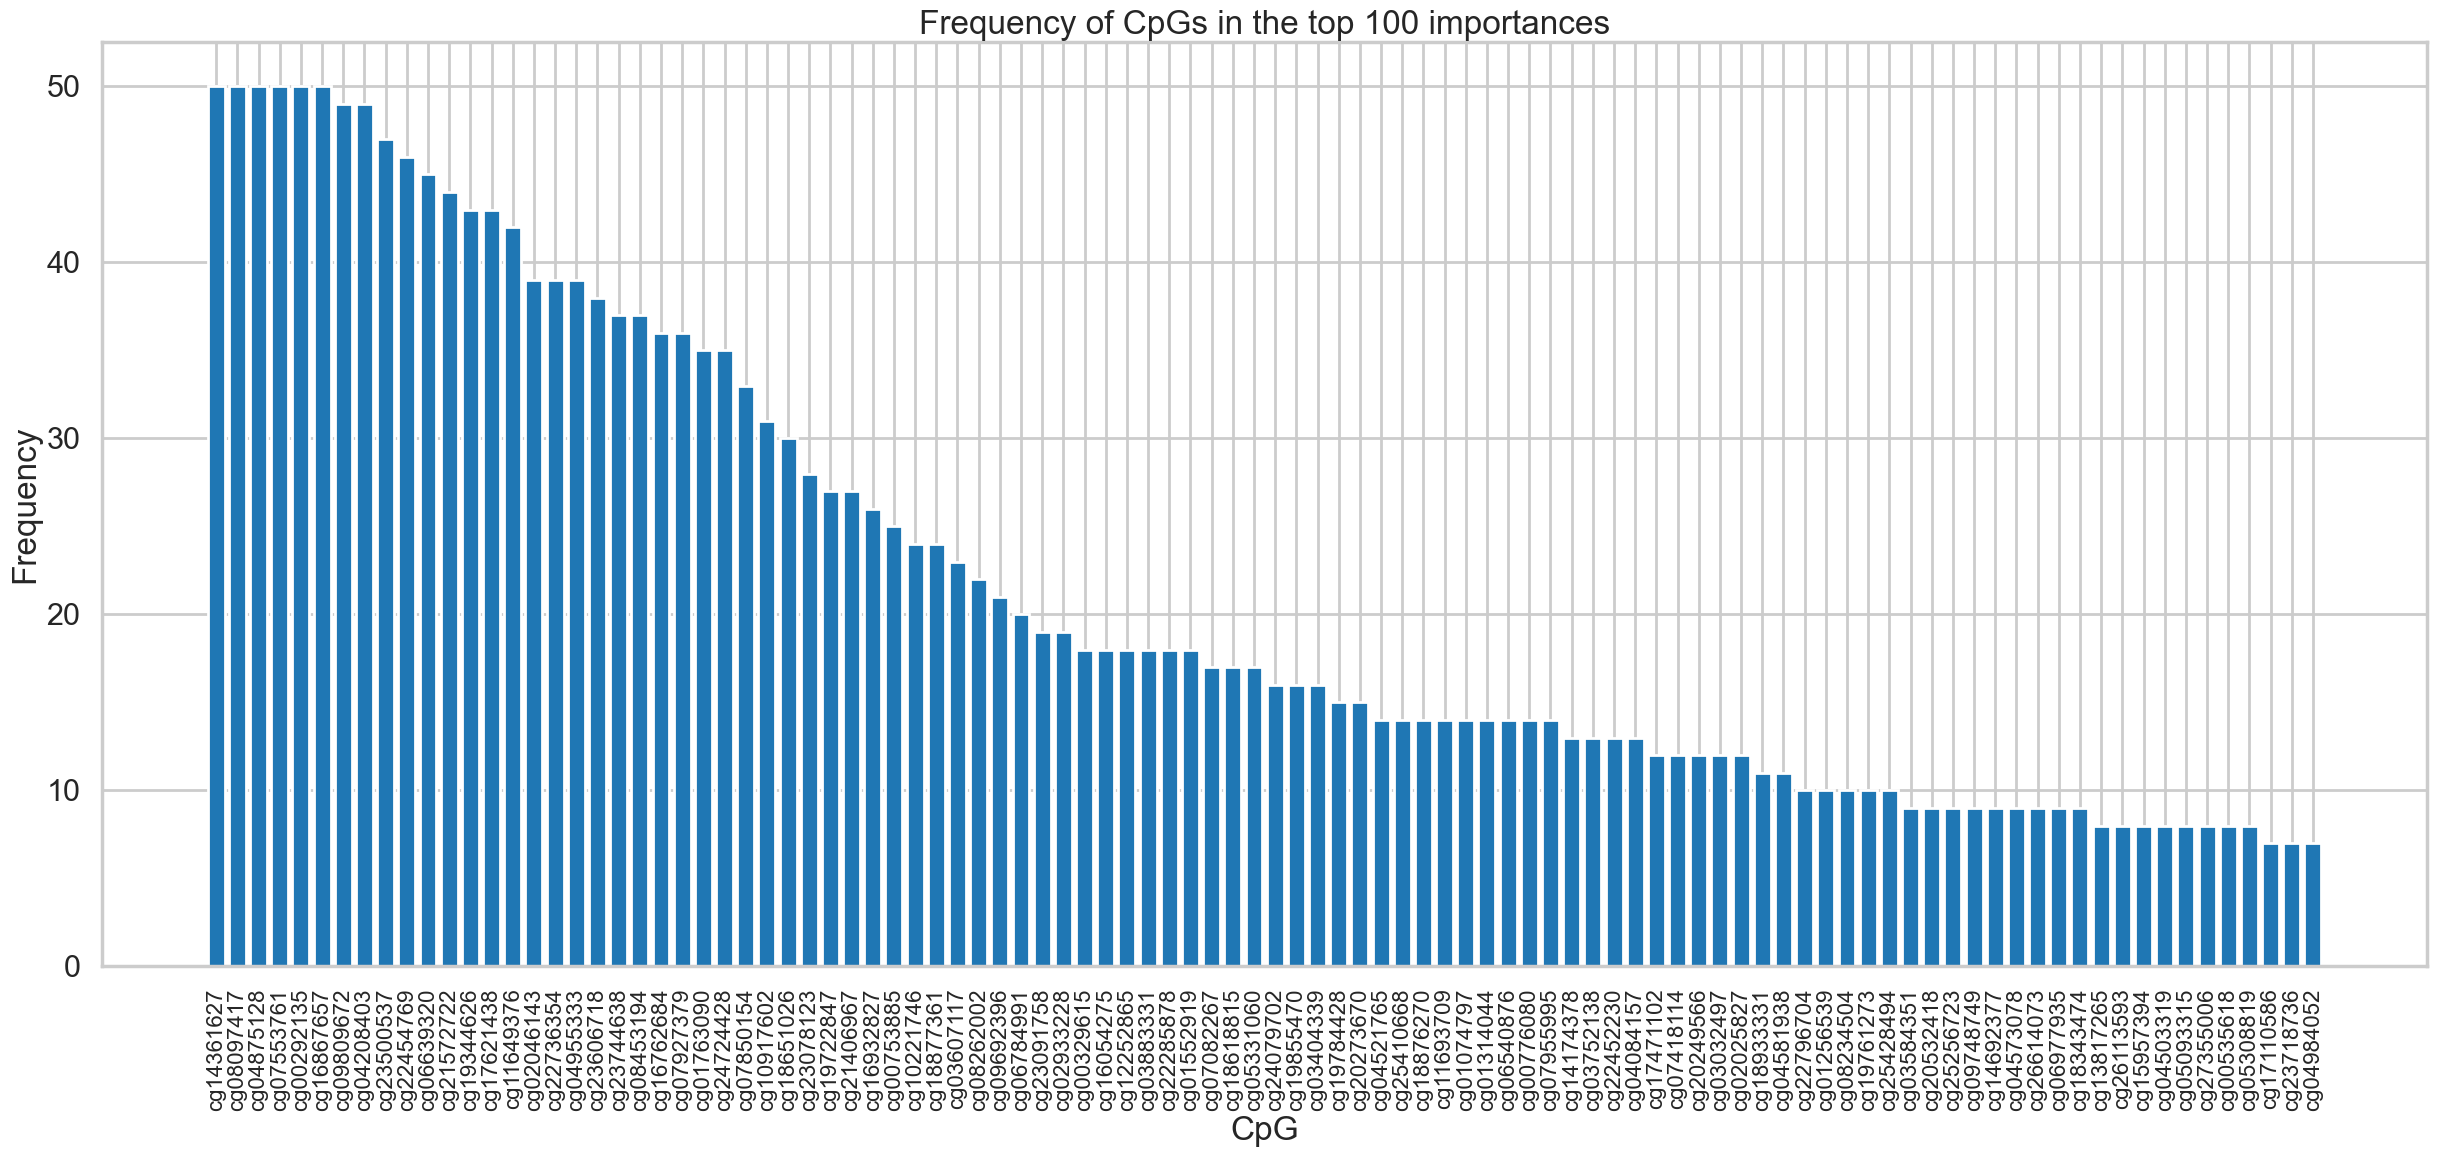

In [46]:
# This function makes a histogram of the frequency of cgs in the top 100 in the 50 trials above
inds, vs, h = histogram_of_top_CpGs_by_importance(df_imp, 100)

In [47]:
cpgs_XGboost_ranked = h.index.values

In [48]:
# # Savings Rankings, took 4hrs to get
# import pickle
# file_ranks = 'cpgs_XGboost_'+ tissue_of_interest+ '_ranked'
# with open(file_ranks, 'wb') as fp:
#     pickle.dump(cpgs_XGboost_ranked, fp)

### Modeling with top 100 cpgs And adding a column for sex

In [49]:
Top100_cpgs_XGboost = h.index[:100].values
plt.rcdefaults()

In [50]:
from sklearn.model_selection import train_test_split
X = df_p_working[Top100_cpgs_XGboost]
X.insert(0, 'sex', df_p_working.sex)  # ADDED COLUMN FOR SEX
y = df_p_working.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

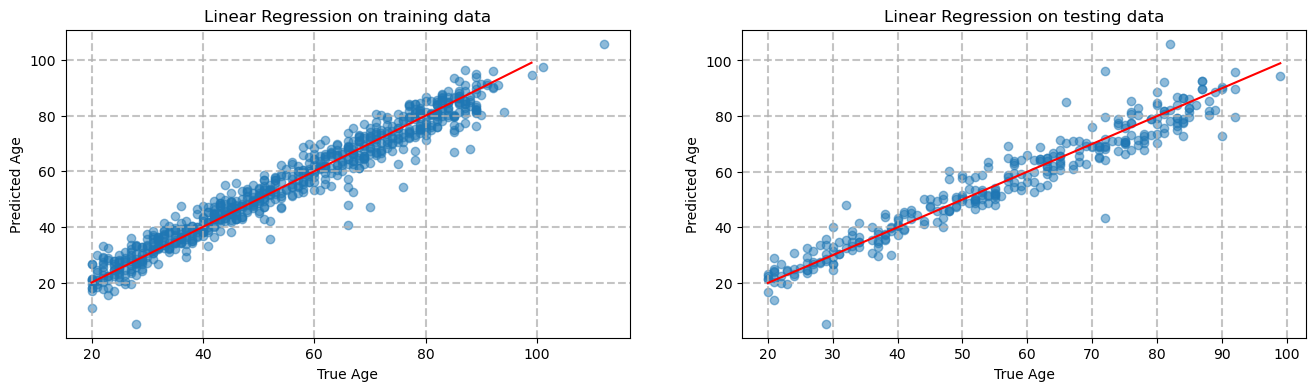

The rms on the training data is 4.651 years
The rms on the testing data is 5.428 years
The r^2 on the training data is 0.949
The r^2 on the testing data is 0.928
The MAe on the training data is 3.463 years
The MAE on the testing data is 3.906


In [67]:
plt.rcdefaults()
mod_100, rms_train, rms_test, r2_train, r2_test = linear_regress(X_train, y_train, X_test, y_test, plot=True)

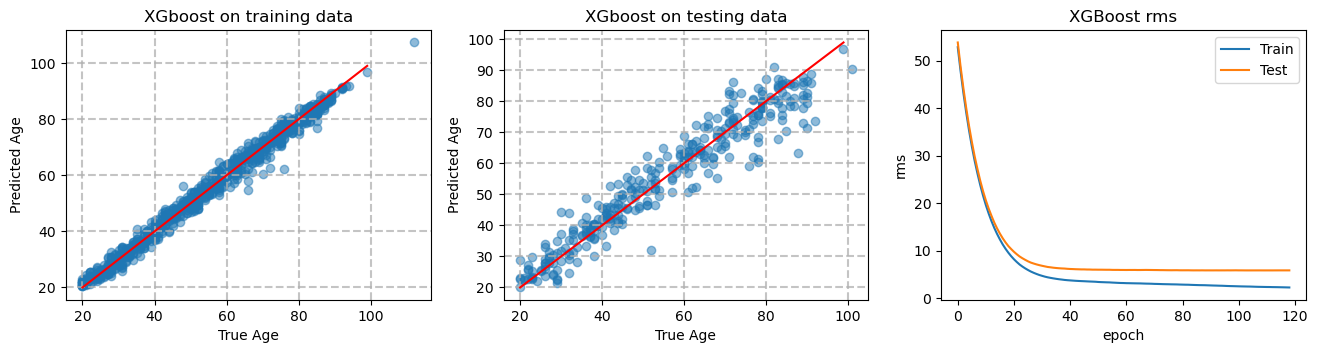

The number of training epochs was 119
The rms on the training data is 2.388 years
The rms on the testing data is 5.868 years
The r^2 on the training data is 0.986
The r^2 on the testing data is 0.919
The MAE on the training data is 1.849 years
The MAE on the testing data is 4.348 years


In [52]:
XG_100, rms_train, rms_test, r2_train, r2_test, feature_importances_ = xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=10, plot=True)

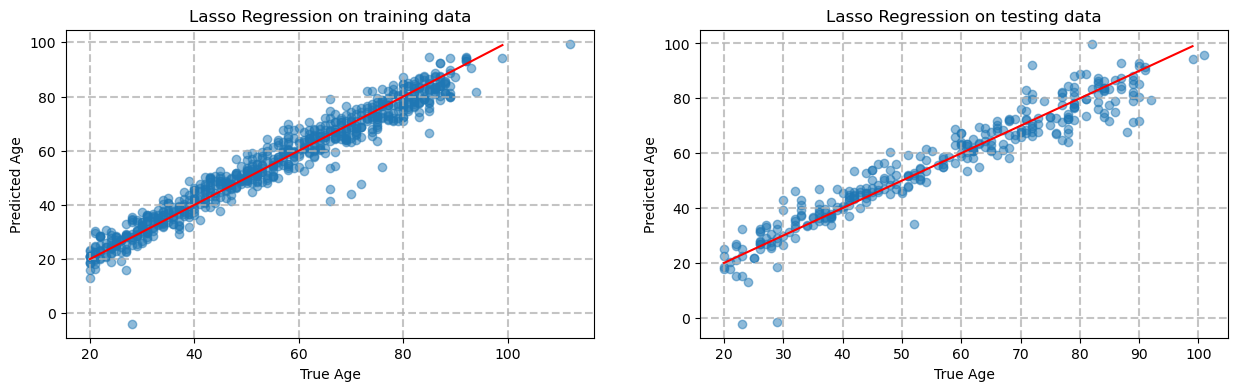

The rms on the training data is 4.678 years
The rms on the testing data is 5.915 years
The r^2 on the training data is 0.948
The r^2 on the testing data is 0.917
The MAE on the training data is 3.399 years
The MAE on the testing data is 4.195 years
Optimal alpha from CV = 0.01


In [53]:
mod_lasso_100, rms_train, rms_test, r2_train, r2_test = lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

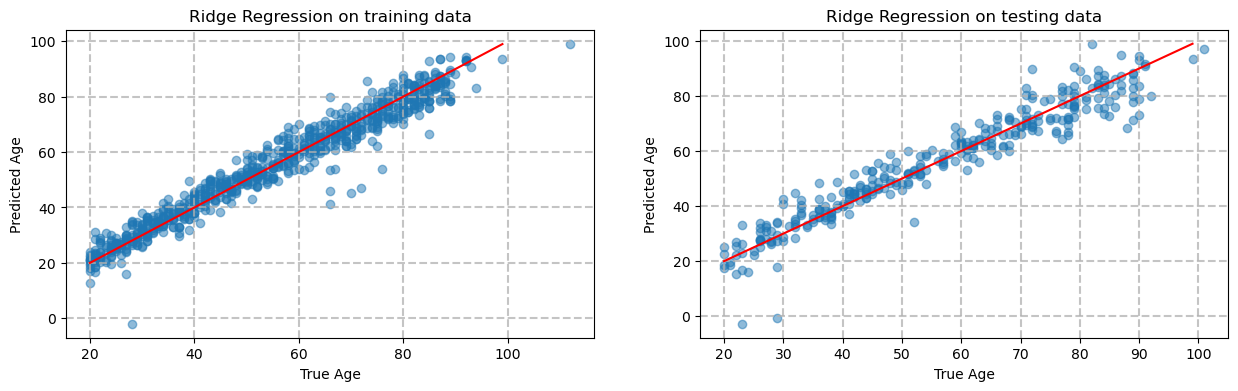

The rms on the training data is 4.670 years
The rms on the testing data is 5.774 years
The r^2 on the training data is 0.948
The r^2 on the testing data is 0.921
The MAE on the training data is 3.392 years
The MAE on the testing data is 4.084 years
Optimal alpha from CV = 1.0


In [54]:
mod_ridge_100, rms_train, rms_test, r2_train, r2_test = ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

In [55]:
# Save models
import pickle

with open('mod_100_whole_blood', 'wb') as fp:
    pickle.dump(mod_100, fp)
    
with open('XG_100_whole_blood', 'wb') as fp:
    pickle.dump(XG_100, fp)
    
with open('mod_lasso_100_whole_blood', 'wb') as fp:
    pickle.dump(mod_lasso_100, fp)
    
with open('mod_ridge_100_whole_blood', 'wb') as fp:
    pickle.dump(mod_ridge_100, fp)

### Model Perfomance on Heldout Data

In [58]:
X_saved = df_p_saved[Top100_cpgs_XGboost]
X_saved.insert(0, 'sex', df_p_saved.sex)  # ADDED COLUMN FOR SEX
y_saved = df_p_saved.age

In [59]:
X_saved.shape

(356, 101)

In [60]:
plt.rcdefaults()

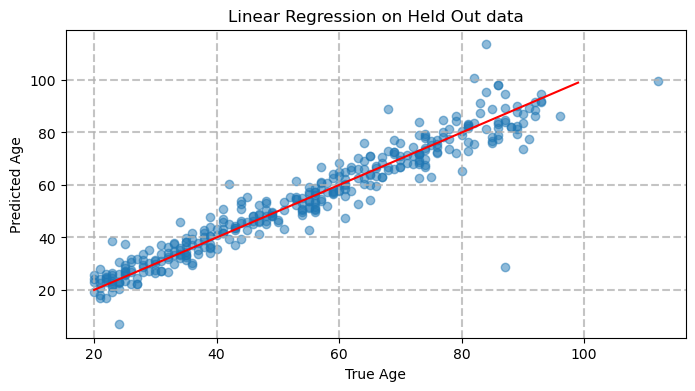

The MSE on the saved data is 38.305 years
The rms on the saved data is 6.189 years
The r^2 on the saved data is 0.915
The mae on the saved data is 4.051 years
The correlation on the held out data true-predicted is 0.957


In [61]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_100, mtype='Linear Regression', figsize=(8,4), xlim=None)

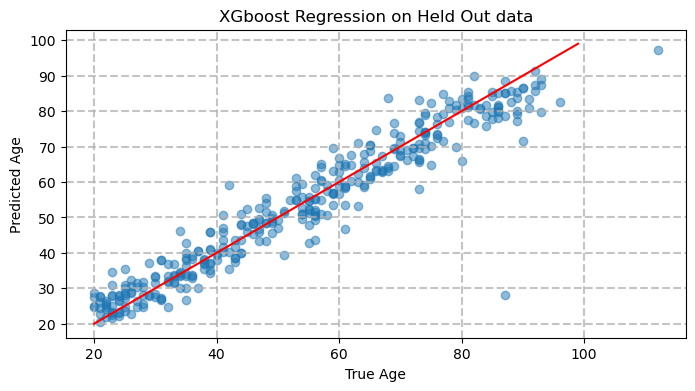

The MSE on the saved data is 35.492 years
The rms on the saved data is 5.957 years
The r^2 on the saved data is 0.921
The mae on the saved data is 4.094 years
The correlation on the held out data true-predicted is 0.960


In [62]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, XG_100, mtype='XGboost Regression', figsize=(8,4), xlim=None)

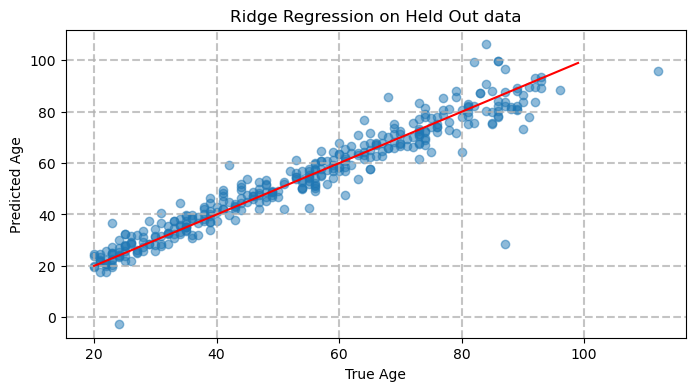

The MSE on the saved data is 36.857 years
The rms on the saved data is 6.071 years
The r^2 on the saved data is 0.918
The mae on the saved data is 3.878 years
The correlation on the held out data true-predicted is 0.958


In [63]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_ridge_100, mtype='Ridge Regression', figsize=(8,4), xlim=None)

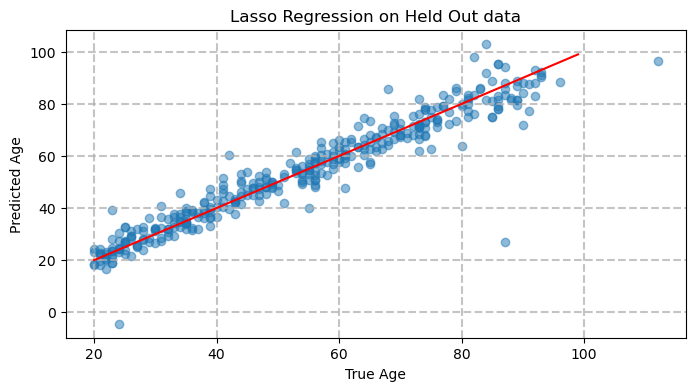

The MSE on the saved data is 36.921 years
The rms on the saved data is 6.076 years
The r^2 on the saved data is 0.918
The mae on the saved data is 3.844 years
The correlation on the held out data true-predicted is 0.958


In [64]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_lasso_100, mtype='Lasso Regression', figsize=(8,4), xlim=None)

The rms on the training data is 4.982 years
The rms on the testing data is 5.443 years
The r^2 on the training data is 0.939
The r^2 on the testing data is 0.934
The MAE on the training data is 3.625 years
The MAE on the testing data is 3.732 years
Optimal alpha from CV = 0.01
The rms on the training data is 4.569 years
The rms on the testing data is 5.506 years
The r^2 on the training data is 0.949
The r^2 on the testing data is 0.931
The MAE on the training data is 3.343 years
The MAE on the testing data is 4.053 years
Optimal alpha from CV = 0.001
The rms on the training data is 4.921 years
The rms on the testing data is 5.478 years
The r^2 on the training data is 0.942
The r^2 on the testing data is 0.930
The MAE on the training data is 3.546 years
The MAE on the testing data is 3.904 years
Optimal alpha from CV = 0.01
The rms on the training data is 5.104 years
The rms on the testing data is 4.939 years
The r^2 on the training data is 0.939
The r^2 on the testing data is 0.941
The

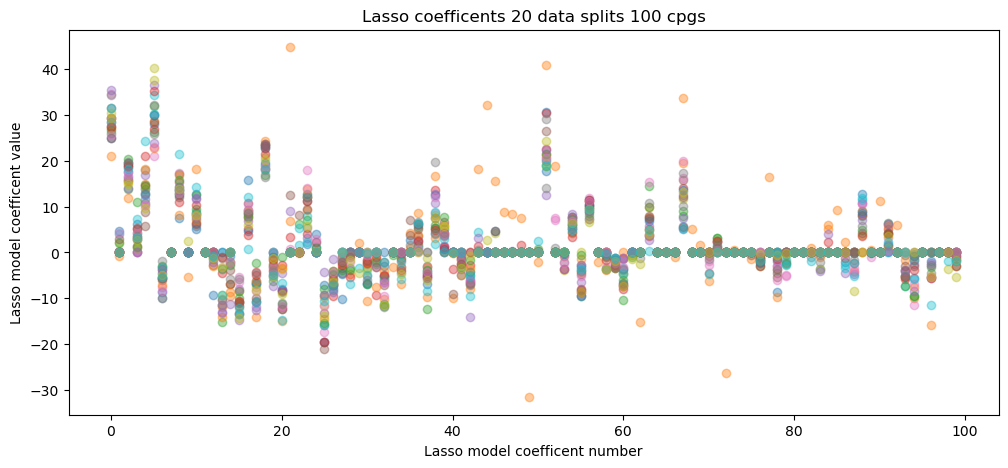

In [65]:
# Looking at Lasso Coefficents 20 data splits to see how split-dependent they are.
plt.figure(figsize = (12, 5))
plt.xlabel('Lasso model coefficent number')
plt.ylabel('Lasso model coefficent value')
plt.title('Lasso coefficents 20 data splits 100 cpgs')
coefs_list = []
for i in range(20):
    X = df_p_working[Top100_cpgs_XGboost]
    y = df_p_working.age
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = i+100)
    model_l, rms_train, rms_test, r2_train, r2_test = lassoCV_regress(X_train, y_train, X_test, y_test, plot=False, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)
    coefs_list.append(model_l.coef_)
    plt.scatter(range(100),model_l.coef_, alpha=0.4 )
plt.show()
